# Loading the Brown Corpus
    We first load in the Brown Corpus and define functions for getting sentences from the corpus and converting sentences to word indexes. 
    

In [1]:
# This notebook has been highly inspired by the materials thought in Udemy's course "Natural Language Processing with Deep Learning in Python".
from __future__ import print_function, division
from builtins import range
import nltk
from nltk.corpus import brown
import operator
nltk.download('brown')

KEEP_WORDS = set([
  'king', 'man', 'queen', 'woman',
  'italy', 'rome', 'france', 'paris',
  'london', 'britain', 'england',
])


def get_sentences():

    return brown.sents()


def get_sentences_with_word2idx():
    sentences = get_sentences()
    indexed_sentences = []

    i = 2
    word2idx = {'START': 0, 'END': 1}
    for sentence in sentences:
        indexed_sentence = []
        for token in sentence:
            token = token.lower()
            if token not in word2idx:
                word2idx[token] = i
                i += 1

            indexed_sentence.append(word2idx[token])
        indexed_sentences.append(indexed_sentence)

    print("Vocab size:", i)
    return indexed_sentences, word2idx


def get_sentences_with_word2idx_limit_vocab(n_vocab=2000, keep_words=KEEP_WORDS):
    sentences = get_sentences()
    indexed_sentences = []

    i = 2
    word2idx = {'START': 0, 'END': 1}
    idx2word = ['START', 'END']

    word_idx_count = {
    0: float('inf'),
    1: float('inf'),
    }

    for sentence in sentences:
        indexed_sentence = []
        for token in sentence:
            token = token.lower()
            if token not in word2idx:
                idx2word.append(token)
                word2idx[token] = i
                i += 1

      # keep track of counts for later sorting
            idx = word2idx[token]
            word_idx_count[idx] = word_idx_count.get(idx, 0) + 1

            indexed_sentence.append(idx)
        indexed_sentences.append(indexed_sentence)



    # restrict vocab size

    # set all the words I want to keep to infinity
    # so that they are included when I pick the most
    # common words
    for word in keep_words:
        word_idx_count[word2idx[word]] = float('inf')

    sorted_word_idx_count = sorted(word_idx_count.items(), key=operator.itemgetter(1), reverse=True)
    word2idx_small = {}
    new_idx = 0
    idx_new_idx_map = {}
    for idx, count in sorted_word_idx_count[:n_vocab]:
        word = idx2word[idx]
        print(word, count)
        word2idx_small[word] = new_idx
        idx_new_idx_map[idx] = new_idx
        new_idx += 1
    # let 'unknown' be the last token
    word2idx_small['UNKNOWN'] = new_idx 
    unknown = new_idx

    assert('START' in word2idx_small)
    assert('END' in word2idx_small)
    for word in keep_words:
        assert(word in word2idx_small)

    # map old idx to new idx
    sentences_small = []
    for sentence in indexed_sentences:
        if len(sentence) > 1:
            new_sentence = [idx_new_idx_map[idx] if idx in idx_new_idx_map else unknown for idx in sentence]
            sentences_small.append(new_sentence)

    return sentences_small, word2idx_small

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\RS\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


 We use the same function used in the "Bigram Model" notebook for computing the bigram probabilities using counts.

In [2]:
from __future__ import print_function, division
from future.utils import iteritems
from builtins import range, input
import numpy as np
import os
import sys
sys.path.append(os.path.abspath('..'))



def get_bigram_probs(sentences, V, start_idx, end_idx, smoothing=1):
    # structure of bigram probability matrix will be:
    # (last word, current word) --> probability
    # we will use add-1 smoothing
    # note: we'll always ignore this from the END token
    bigram_probs = np.ones((V, V)) * smoothing
    for sentence in sentences:
        for i in range(len(sentence)):
            
            if i == 0:
                # beginning word
                bigram_probs[start_idx, sentence[i]] += 1
            else:
                # middle word
                bigram_probs[sentence[i-1], sentence[i]] += 1

            # if we're at the final word
            # we update the bigram for last -> current
            # AND current -> END token
            if i == len(sentence) - 1:
                # final word
                bigram_probs[sentence[i], end_idx] += 1

    # normalize the counts along the rows to get probabilities
    bigram_probs /= bigram_probs.sum(axis=1, keepdims=True)
    return bigram_probs


# Builiding a Neural Bigram Model.
        In what follows, we create a Neural bigram model using Logistic Regression. We represent the words as numbers with 
        one-hot encoding. 
        We use softmax for computing the probability of each bigram and we find the weights of the neural model by doing 
        gradient descent on the cost. We then train a logistic model and analyze the loss with respcet to the chosen weights 
        for the model.

START inf
END inf
man inf
paris inf
britain inf
england inf
king inf
woman inf
rome inf
london inf
queen inf
italy inf
france inf
the 69971
, 58334
. 49346
of 36412
and 28853
to 26158
a 23195
in 21337
that 10594
is 10109
was 9815
he 9548
for 9489
`` 8837
'' 8789
it 8760
with 7289
as 7253
his 6996
on 6741
be 6377
; 5566
at 5372
by 5306
i 5164
this 5145
had 5133
? 4693
not 4610
are 4394
but 4381
from 4370
or 4206
have 3942
an 3740
they 3620
which 3561
-- 3432
one 3292
you 3286
were 3284
her 3036
all 3001
she 2860
there 2728
would 2714
their 2669
we 2652
him 2619
been 2472
) 2466
has 2437
( 2435
when 2331
who 2252
will 2245
more 2215
if 2198
no 2139
out 2097
so 1985
said 1961
what 1908
up 1890
its 1858
about 1815
: 1795
into 1791
than 1790
them 1788
can 1772
only 1748
other 1702
new 1635
some 1618
could 1601
time 1598
! 1596
these 1573
two 1412
may 1402
then 1380
do 1363
first 1361
any 1344
my 1318
now 1314
such 1303
like 1292
our 1252
over 1236
me 1181
even 1170
most 1159
made 1125
also 

regard 89
published 89
famous 89
develop 89
clothes 89
laws 88
announced 88
carry 88
cover 88
moreover 88
add 88
greatest 88
check 88
enemy 88
leaving 88
key 88
manager 88
doesn't 88
active 88
break 88
bottom 88
pain 88
relationship 88
sources 88
poetry 88
assistance 87
operating 87
battle 87
companies 87
fixed 87
possibility 87
mary 87
product 87
spoke 87
units 87
touch 87
bright 87
finished 87
carefully 87
facts 87
previous 86
citizens 86
takes 86
e. 86
allowed 86
require 86
workers 86
build 86
patient 86
financial 86
philosophy 86
loss 86
rose 86
died 86
scientific 86
otherwise 86
inches 86
significant 86
seeing 86
distribution 85
marked 85
post 85
rules 85
capital 85
captain 85
relatively 85
classes 85
variety 85
stated 85
shape 85
stations 85
german 85
musical 85
concept 85
reports 84
proposed 84
w. 84
begin 84
impossible 84
affairs 84
named 84
circumstances 84
learn 84
remains 84
appears 84
strange 84
catholic 84
operations 84
collection 84
aware 84
sex 84
broad 84
henry 83
rober

Vocab size: 2001
epoch: 0 sentence: 0/57013 loss: 7.590247326288033
epoch: 0 sentence: 10/57013 loss: 7.524983500106795
epoch: 0 sentence: 20/57013 loss: 7.417976398596095
epoch: 0 sentence: 30/57013 loss: 7.159327750007629
epoch: 0 sentence: 40/57013 loss: 7.496420004722406
epoch: 0 sentence: 50/57013 loss: 7.195683505423815
epoch: 0 sentence: 60/57013 loss: 7.356212343498763
epoch: 0 sentence: 70/57013 loss: 6.439084746742359
epoch: 0 sentence: 80/57013 loss: 6.186312102114558
epoch: 0 sentence: 90/57013 loss: 6.474580556696048
epoch: 0 sentence: 100/57013 loss: 7.193029376273685
epoch: 0 sentence: 110/57013 loss: 6.934922522679768
epoch: 0 sentence: 120/57013 loss: 5.877650645478499
epoch: 0 sentence: 130/57013 loss: 6.755899514786217
epoch: 0 sentence: 140/57013 loss: 6.780439461335558
epoch: 0 sentence: 150/57013 loss: 7.108149682794847
epoch: 0 sentence: 160/57013 loss: 4.221488377827147
epoch: 0 sentence: 170/57013 loss: 6.629490638555596
epoch: 0 sentence: 180/57013 loss: 6.829

epoch: 0 sentence: 1540/57013 loss: 5.958083680966484
epoch: 0 sentence: 1550/57013 loss: 5.299595997338188
epoch: 0 sentence: 1560/57013 loss: 4.8633956231822495
epoch: 0 sentence: 1570/57013 loss: 4.708282552764416
epoch: 0 sentence: 1580/57013 loss: 6.567218331772588
epoch: 0 sentence: 1590/57013 loss: 5.1690251251007835
epoch: 0 sentence: 1600/57013 loss: 4.234560073353827
epoch: 0 sentence: 1610/57013 loss: 5.224966030747843
epoch: 0 sentence: 1620/57013 loss: 6.1728181470051755
epoch: 0 sentence: 1630/57013 loss: 4.954636881375154
epoch: 0 sentence: 1640/57013 loss: 5.593931488624042
epoch: 0 sentence: 1650/57013 loss: 5.890499744450842
epoch: 0 sentence: 1660/57013 loss: 4.694651287860924
epoch: 0 sentence: 1670/57013 loss: 5.570825231740808
epoch: 0 sentence: 1680/57013 loss: 4.078556765954668
epoch: 0 sentence: 1690/57013 loss: 4.708035006377319
epoch: 0 sentence: 1700/57013 loss: 4.503151222775891
epoch: 0 sentence: 1710/57013 loss: 6.618099393347705
epoch: 0 sentence: 1720/5

epoch: 0 sentence: 3060/57013 loss: 6.306224404612651
epoch: 0 sentence: 3070/57013 loss: 5.417798124415726
epoch: 0 sentence: 3080/57013 loss: 5.502766934991007
epoch: 0 sentence: 3090/57013 loss: 4.730655796746388
epoch: 0 sentence: 3100/57013 loss: 6.045747143310568
epoch: 0 sentence: 3110/57013 loss: 6.060372181059595
epoch: 0 sentence: 3120/57013 loss: 4.215413441651775
epoch: 0 sentence: 3130/57013 loss: 6.783120194557708
epoch: 0 sentence: 3140/57013 loss: 3.6337623865103175
epoch: 0 sentence: 3150/57013 loss: 4.41818740324127
epoch: 0 sentence: 3160/57013 loss: 4.61548850390512
epoch: 0 sentence: 3170/57013 loss: 5.523661334600741
epoch: 0 sentence: 3180/57013 loss: 5.771202918640599
epoch: 0 sentence: 3190/57013 loss: 5.797821488113204
epoch: 0 sentence: 3200/57013 loss: 4.683324175138983
epoch: 0 sentence: 3210/57013 loss: 5.238284409743793
epoch: 0 sentence: 3220/57013 loss: 6.025539038156652
epoch: 0 sentence: 3230/57013 loss: 5.850377402477831
epoch: 0 sentence: 3240/57013

epoch: 0 sentence: 4580/57013 loss: 5.638055075360533
epoch: 0 sentence: 4590/57013 loss: 6.0875400466506315
epoch: 0 sentence: 4600/57013 loss: 5.650537364251037
epoch: 0 sentence: 4610/57013 loss: 3.9560341174586693
epoch: 0 sentence: 4620/57013 loss: 5.090556821761509
epoch: 0 sentence: 4630/57013 loss: 4.352065381541809
epoch: 0 sentence: 4640/57013 loss: 3.425003120690361
epoch: 0 sentence: 4650/57013 loss: 5.454061462368559
epoch: 0 sentence: 4660/57013 loss: 4.366805226273445
epoch: 0 sentence: 4670/57013 loss: 6.473334741531848
epoch: 0 sentence: 4680/57013 loss: 4.746563865374018
epoch: 0 sentence: 4690/57013 loss: 4.9875561729473645
epoch: 0 sentence: 4700/57013 loss: 6.744287784288807
epoch: 0 sentence: 4710/57013 loss: 4.9574758008719595
epoch: 0 sentence: 4720/57013 loss: 4.076356113460956
epoch: 0 sentence: 4730/57013 loss: 4.821282050403759
epoch: 0 sentence: 4740/57013 loss: 5.889607945961871
epoch: 0 sentence: 4750/57013 loss: 4.580027898208254
epoch: 0 sentence: 4760/

epoch: 0 sentence: 6100/57013 loss: 3.8817864819998573
epoch: 0 sentence: 6110/57013 loss: 3.23111498324293
epoch: 0 sentence: 6120/57013 loss: 4.907367746121429
epoch: 0 sentence: 6130/57013 loss: 6.694769028576287
epoch: 0 sentence: 6140/57013 loss: 4.926992313432479
epoch: 0 sentence: 6150/57013 loss: 5.7971941539035985
epoch: 0 sentence: 6160/57013 loss: 3.303270531250487
epoch: 0 sentence: 6170/57013 loss: 4.276280982242232
epoch: 0 sentence: 6180/57013 loss: 3.6183354324449377
epoch: 0 sentence: 6190/57013 loss: 5.663640242281123
epoch: 0 sentence: 6200/57013 loss: 4.71510335877421
epoch: 0 sentence: 6210/57013 loss: 3.8162179382717234
epoch: 0 sentence: 6220/57013 loss: 5.188244794005285
epoch: 0 sentence: 6230/57013 loss: 4.523029690048151
epoch: 0 sentence: 6240/57013 loss: 4.135311860624031
epoch: 0 sentence: 6250/57013 loss: 5.491360012913319
epoch: 0 sentence: 6260/57013 loss: 4.321519518119497
epoch: 0 sentence: 6270/57013 loss: 6.08837109335738
epoch: 0 sentence: 6280/570

epoch: 0 sentence: 7620/57013 loss: 5.695179898218823
epoch: 0 sentence: 7630/57013 loss: 3.9517941183982206
epoch: 0 sentence: 7640/57013 loss: 5.832775457278458
epoch: 0 sentence: 7650/57013 loss: 6.246155759352991
epoch: 0 sentence: 7660/57013 loss: 5.251620854123572
epoch: 0 sentence: 7670/57013 loss: 4.650426059216959
epoch: 0 sentence: 7680/57013 loss: 5.756651561871808
epoch: 0 sentence: 7690/57013 loss: 4.1419230044096516
epoch: 0 sentence: 7700/57013 loss: 5.416538855732885
epoch: 0 sentence: 7710/57013 loss: 4.879636173149462
epoch: 0 sentence: 7720/57013 loss: 3.8556895926772543
epoch: 0 sentence: 7730/57013 loss: 5.265265072264207
epoch: 0 sentence: 7740/57013 loss: 5.874362041100927
epoch: 0 sentence: 7750/57013 loss: 4.681062108313758
epoch: 0 sentence: 7760/57013 loss: 5.3656302666743505
epoch: 0 sentence: 7770/57013 loss: 5.300491817872325
epoch: 0 sentence: 7780/57013 loss: 6.032163525631041
epoch: 0 sentence: 7790/57013 loss: 4.902970879165809
epoch: 0 sentence: 7800/

epoch: 0 sentence: 9140/57013 loss: 6.083291162183202
epoch: 0 sentence: 9150/57013 loss: 4.718106882296964
epoch: 0 sentence: 9160/57013 loss: 5.24396159390528
epoch: 0 sentence: 9170/57013 loss: 4.155105903913898
epoch: 0 sentence: 9180/57013 loss: 4.431793616400919
epoch: 0 sentence: 9190/57013 loss: 4.302291396539826
epoch: 0 sentence: 9200/57013 loss: 6.21290239979646
epoch: 0 sentence: 9210/57013 loss: 3.179447621078511
epoch: 0 sentence: 9220/57013 loss: 5.818340749041552
epoch: 0 sentence: 9230/57013 loss: 5.401068519327139
epoch: 0 sentence: 9240/57013 loss: 5.0674014294630005
epoch: 0 sentence: 9250/57013 loss: 4.343185200524427
epoch: 0 sentence: 9260/57013 loss: 4.324845725241934
epoch: 0 sentence: 9270/57013 loss: 4.705564250775127
epoch: 0 sentence: 9280/57013 loss: 6.027748988904477
epoch: 0 sentence: 9290/57013 loss: 4.814633698080277
epoch: 0 sentence: 9300/57013 loss: 4.177045075824313
epoch: 0 sentence: 9310/57013 loss: 4.851856545716206
epoch: 0 sentence: 9320/57013

epoch: 0 sentence: 10650/57013 loss: 5.7656043108086585
epoch: 0 sentence: 10660/57013 loss: 3.40347867850626
epoch: 0 sentence: 10670/57013 loss: 5.346442768823979
epoch: 0 sentence: 10680/57013 loss: 6.280816576065229
epoch: 0 sentence: 10690/57013 loss: 4.825621216766902
epoch: 0 sentence: 10700/57013 loss: 6.1089891665366975
epoch: 0 sentence: 10710/57013 loss: 5.405916684762533
epoch: 0 sentence: 10720/57013 loss: 4.519248351353201
epoch: 0 sentence: 10730/57013 loss: 6.628782305602338
epoch: 0 sentence: 10740/57013 loss: 5.490056794589413
epoch: 0 sentence: 10750/57013 loss: 5.344675693113334
epoch: 0 sentence: 10760/57013 loss: 5.340658319724959
epoch: 0 sentence: 10770/57013 loss: 3.3056688844773054
epoch: 0 sentence: 10780/57013 loss: 5.574963441754448
epoch: 0 sentence: 10790/57013 loss: 6.533614224290017
epoch: 0 sentence: 10800/57013 loss: 4.660730569331066
epoch: 0 sentence: 10810/57013 loss: 3.412105879688539
epoch: 0 sentence: 10820/57013 loss: 5.174648968658444
epoch: 0

epoch: 0 sentence: 12140/57013 loss: 4.7915527901408055
epoch: 0 sentence: 12150/57013 loss: 4.7918535201327765
epoch: 0 sentence: 12160/57013 loss: 5.1779666699107505
epoch: 0 sentence: 12170/57013 loss: 7.020046899253397
epoch: 0 sentence: 12180/57013 loss: 5.020292134583019
epoch: 0 sentence: 12190/57013 loss: 4.455071484936949
epoch: 0 sentence: 12200/57013 loss: 5.462026798860073
epoch: 0 sentence: 12210/57013 loss: 4.1143354454238645
epoch: 0 sentence: 12220/57013 loss: 3.985127499463132
epoch: 0 sentence: 12230/57013 loss: 2.9899098526117465
epoch: 0 sentence: 12240/57013 loss: 5.575816011165019
epoch: 0 sentence: 12250/57013 loss: 5.033473079759115
epoch: 0 sentence: 12260/57013 loss: 5.0450447821400255
epoch: 0 sentence: 12270/57013 loss: 4.574891221279937
epoch: 0 sentence: 12280/57013 loss: 4.224121735879778
epoch: 0 sentence: 12290/57013 loss: 5.331571136039998
epoch: 0 sentence: 12300/57013 loss: 4.308554927007084
epoch: 0 sentence: 12310/57013 loss: 2.6155456696000225
epo

epoch: 0 sentence: 13630/57013 loss: 5.611946413277647
epoch: 0 sentence: 13640/57013 loss: 5.079021614823609
epoch: 0 sentence: 13650/57013 loss: 2.6133890673442495
epoch: 0 sentence: 13660/57013 loss: 4.737113730526408
epoch: 0 sentence: 13670/57013 loss: 5.566642382198578
epoch: 0 sentence: 13680/57013 loss: 4.179729374915368
epoch: 0 sentence: 13690/57013 loss: 5.499483209710083
epoch: 0 sentence: 13700/57013 loss: 5.124709305662703
epoch: 0 sentence: 13710/57013 loss: 3.739463989943229
epoch: 0 sentence: 13720/57013 loss: 5.376988854574009
epoch: 0 sentence: 13730/57013 loss: 4.713586328133307
epoch: 0 sentence: 13740/57013 loss: 5.585226526673862
epoch: 0 sentence: 13750/57013 loss: 5.44259884461974
epoch: 0 sentence: 13760/57013 loss: 4.796053210278674
epoch: 0 sentence: 13770/57013 loss: 2.465054419260831
epoch: 0 sentence: 13780/57013 loss: 4.0208381211110025
epoch: 0 sentence: 13790/57013 loss: 4.950349941931715
epoch: 0 sentence: 13800/57013 loss: 4.914372329609362
epoch: 0 

epoch: 0 sentence: 15120/57013 loss: 5.102392148521863
epoch: 0 sentence: 15130/57013 loss: 5.334374407611252
epoch: 0 sentence: 15140/57013 loss: 4.527769013720399
epoch: 0 sentence: 15150/57013 loss: 3.410440598198905
epoch: 0 sentence: 15160/57013 loss: 5.998711275730712
epoch: 0 sentence: 15170/57013 loss: 4.888715433224335
epoch: 0 sentence: 15180/57013 loss: 5.601634990868864
epoch: 0 sentence: 15190/57013 loss: 5.145342859372366
epoch: 0 sentence: 15200/57013 loss: 4.913219697831232
epoch: 0 sentence: 15210/57013 loss: 5.013848379946557
epoch: 0 sentence: 15220/57013 loss: 6.101787398661815
epoch: 0 sentence: 15230/57013 loss: 5.458286571117252
epoch: 0 sentence: 15240/57013 loss: 4.774977590978041
epoch: 0 sentence: 15250/57013 loss: 4.276564544534367
epoch: 0 sentence: 15260/57013 loss: 4.7318972223593905
epoch: 0 sentence: 15270/57013 loss: 5.874037154978499
epoch: 0 sentence: 15280/57013 loss: 3.2375560970902284
epoch: 0 sentence: 15290/57013 loss: 3.3110829714925027
epoch: 

epoch: 0 sentence: 16610/57013 loss: 5.575904661492884
epoch: 0 sentence: 16620/57013 loss: 5.057940037617898
epoch: 0 sentence: 16630/57013 loss: 4.637998185325588
epoch: 0 sentence: 16640/57013 loss: 4.928336519406305
epoch: 0 sentence: 16650/57013 loss: 4.293356835939535
epoch: 0 sentence: 16660/57013 loss: 4.866785088986185
epoch: 0 sentence: 16670/57013 loss: 4.1183029286930335
epoch: 0 sentence: 16680/57013 loss: 3.871099652076986
epoch: 0 sentence: 16690/57013 loss: 5.067783243234685
epoch: 0 sentence: 16700/57013 loss: 4.86315384202117
epoch: 0 sentence: 16710/57013 loss: 6.123861767959389
epoch: 0 sentence: 16720/57013 loss: 5.516970477298527
epoch: 0 sentence: 16730/57013 loss: 4.33230372315597
epoch: 0 sentence: 16740/57013 loss: 4.2923234135944535
epoch: 0 sentence: 16750/57013 loss: 6.765786975578739
epoch: 0 sentence: 16760/57013 loss: 4.893887575487165
epoch: 0 sentence: 16770/57013 loss: 6.226496021418985
epoch: 0 sentence: 16780/57013 loss: 3.9868069682832634
epoch: 0 

epoch: 0 sentence: 18100/57013 loss: 4.125870218553605
epoch: 0 sentence: 18110/57013 loss: 4.736740476008244
epoch: 0 sentence: 18120/57013 loss: 5.287260293282612
epoch: 0 sentence: 18130/57013 loss: 4.670055781059609
epoch: 0 sentence: 18140/57013 loss: 4.571447828665786
epoch: 0 sentence: 18150/57013 loss: 3.174226113646169
epoch: 0 sentence: 18160/57013 loss: 4.636805158161574
epoch: 0 sentence: 18170/57013 loss: 5.1306667137955
epoch: 0 sentence: 18180/57013 loss: 4.58103368625591
epoch: 0 sentence: 18190/57013 loss: 4.16939971918388
epoch: 0 sentence: 18200/57013 loss: 4.60917761570411
epoch: 0 sentence: 18210/57013 loss: 4.780405099648089
epoch: 0 sentence: 18220/57013 loss: 4.885589135384298
epoch: 0 sentence: 18230/57013 loss: 5.344678509399249
epoch: 0 sentence: 18240/57013 loss: 5.532615430509292
epoch: 0 sentence: 18250/57013 loss: 3.578057519799774
epoch: 0 sentence: 18260/57013 loss: 4.572262297535782
epoch: 0 sentence: 18270/57013 loss: 5.05187693027244
epoch: 0 sentenc

epoch: 0 sentence: 19590/57013 loss: 4.7398720515857145
epoch: 0 sentence: 19600/57013 loss: 4.407904639858256
epoch: 0 sentence: 19610/57013 loss: 4.51064164416366
epoch: 0 sentence: 19620/57013 loss: 5.100720669856095
epoch: 0 sentence: 19630/57013 loss: 6.1914090154677295
epoch: 0 sentence: 19640/57013 loss: 5.900464256578153
epoch: 0 sentence: 19650/57013 loss: 4.525958702937969
epoch: 0 sentence: 19660/57013 loss: 4.4092430521500905
epoch: 0 sentence: 19670/57013 loss: 5.63700838891502
epoch: 0 sentence: 19680/57013 loss: 5.807400066235946
epoch: 0 sentence: 19690/57013 loss: 5.091471801818499
epoch: 0 sentence: 19700/57013 loss: 5.691113396590154
epoch: 0 sentence: 19710/57013 loss: 4.33721219545838
epoch: 0 sentence: 19720/57013 loss: 4.01213140286357
epoch: 0 sentence: 19730/57013 loss: 5.910850898550263
epoch: 0 sentence: 19740/57013 loss: 3.988865247097074
epoch: 0 sentence: 19750/57013 loss: 4.6071231970686
epoch: 0 sentence: 19760/57013 loss: 5.571732178155158
epoch: 0 sent

epoch: 0 sentence: 21080/57013 loss: 5.269333105908912
epoch: 0 sentence: 21090/57013 loss: 4.364950491147832
epoch: 0 sentence: 21100/57013 loss: 3.58874224336342
epoch: 0 sentence: 21110/57013 loss: 5.80521108392943
epoch: 0 sentence: 21120/57013 loss: 5.538734144535554
epoch: 0 sentence: 21130/57013 loss: 5.50884035275258
epoch: 0 sentence: 21140/57013 loss: 4.911031677522509
epoch: 0 sentence: 21150/57013 loss: 3.3384340547436433
epoch: 0 sentence: 21160/57013 loss: 5.386456438560095
epoch: 0 sentence: 21170/57013 loss: 5.3430415127367175
epoch: 0 sentence: 21180/57013 loss: 3.825291889824159
epoch: 0 sentence: 21190/57013 loss: 4.6931463210928825
epoch: 0 sentence: 21200/57013 loss: 4.827262220044017
epoch: 0 sentence: 21210/57013 loss: 5.631572533023609
epoch: 0 sentence: 21220/57013 loss: 5.4888472349956965
epoch: 0 sentence: 21230/57013 loss: 3.8634530665649285
epoch: 0 sentence: 21240/57013 loss: 4.455067434741258
epoch: 0 sentence: 21250/57013 loss: 4.9818022045049
epoch: 0 s

epoch: 0 sentence: 22570/57013 loss: 4.575436728219508
epoch: 0 sentence: 22580/57013 loss: 5.073799758271268
epoch: 0 sentence: 22590/57013 loss: 2.8218318936940943
epoch: 0 sentence: 22600/57013 loss: 1.9191655963216903
epoch: 0 sentence: 22610/57013 loss: 5.913199560977271
epoch: 0 sentence: 22620/57013 loss: 5.2805168678552405
epoch: 0 sentence: 22630/57013 loss: 4.474301376581379
epoch: 0 sentence: 22640/57013 loss: 2.4581378448654485
epoch: 0 sentence: 22650/57013 loss: 4.208721306393153
epoch: 0 sentence: 22660/57013 loss: 5.031490314169435
epoch: 0 sentence: 22670/57013 loss: 5.053352595911273
epoch: 0 sentence: 22680/57013 loss: 3.7746240294069815
epoch: 0 sentence: 22690/57013 loss: 4.16000596115514
epoch: 0 sentence: 22700/57013 loss: 4.211527660305327
epoch: 0 sentence: 22710/57013 loss: 4.7986006163104395
epoch: 0 sentence: 22720/57013 loss: 5.870142428608144
epoch: 0 sentence: 22730/57013 loss: 5.02019966114686
epoch: 0 sentence: 22740/57013 loss: 4.318934407869182
epoch:

epoch: 0 sentence: 24060/57013 loss: 5.735227775818795
epoch: 0 sentence: 24070/57013 loss: 4.55330113008985
epoch: 0 sentence: 24080/57013 loss: 4.4293397887302435
epoch: 0 sentence: 24090/57013 loss: 4.927489923952929
epoch: 0 sentence: 24100/57013 loss: 6.00774337856243
epoch: 0 sentence: 24110/57013 loss: 4.807510670703249
epoch: 0 sentence: 24120/57013 loss: 5.392046951189001
epoch: 0 sentence: 24130/57013 loss: 3.3738955481561543
epoch: 0 sentence: 24140/57013 loss: 5.704542807920577
epoch: 0 sentence: 24150/57013 loss: 5.540500103194207
epoch: 0 sentence: 24160/57013 loss: 2.9326501130783655
epoch: 0 sentence: 24170/57013 loss: 3.7317658562543863
epoch: 0 sentence: 24180/57013 loss: 5.853335843923727
epoch: 0 sentence: 24190/57013 loss: 4.535605430784863
epoch: 0 sentence: 24200/57013 loss: 1.5848573955886893
epoch: 0 sentence: 24210/57013 loss: 4.903113217688859
epoch: 0 sentence: 24220/57013 loss: 4.834851504946192
epoch: 0 sentence: 24230/57013 loss: 4.782602937550291
epoch: 

epoch: 0 sentence: 25550/57013 loss: 4.16851307904918
epoch: 0 sentence: 25560/57013 loss: 3.3998457144698198
epoch: 0 sentence: 25570/57013 loss: 4.096993345872659
epoch: 0 sentence: 25580/57013 loss: 4.204065994051145
epoch: 0 sentence: 25590/57013 loss: 5.201328542514786
epoch: 0 sentence: 25600/57013 loss: 3.856211564738674
epoch: 0 sentence: 25610/57013 loss: 4.797357561569226
epoch: 0 sentence: 25620/57013 loss: 5.699163058061794
epoch: 0 sentence: 25630/57013 loss: 4.65725385689414
epoch: 0 sentence: 25640/57013 loss: 5.230531867307599
epoch: 0 sentence: 25650/57013 loss: 5.490367547839954
epoch: 0 sentence: 25660/57013 loss: 4.940751691787877
epoch: 0 sentence: 25670/57013 loss: 4.161122558772422
epoch: 0 sentence: 25680/57013 loss: 4.311087160406488
epoch: 0 sentence: 25690/57013 loss: 4.905435657810035
epoch: 0 sentence: 25700/57013 loss: 4.819173190372568
epoch: 0 sentence: 25710/57013 loss: 5.0990219871586895
epoch: 0 sentence: 25720/57013 loss: 3.117510070732041
epoch: 0 s

epoch: 0 sentence: 27040/57013 loss: 5.244577157103333
epoch: 0 sentence: 27050/57013 loss: 3.729976611262518
epoch: 0 sentence: 27060/57013 loss: 3.968657452742756
epoch: 0 sentence: 27070/57013 loss: 5.446889248346979
epoch: 0 sentence: 27080/57013 loss: 3.1746590546976434
epoch: 0 sentence: 27090/57013 loss: 4.47986945647153
epoch: 0 sentence: 27100/57013 loss: 5.572948288392006
epoch: 0 sentence: 27110/57013 loss: 4.915112340007684
epoch: 0 sentence: 27120/57013 loss: 5.519760235053638
epoch: 0 sentence: 27130/57013 loss: 5.9177588482884405
epoch: 0 sentence: 27140/57013 loss: 5.014012105520106
epoch: 0 sentence: 27150/57013 loss: 6.133737696444708
epoch: 0 sentence: 27160/57013 loss: 4.579470357715874
epoch: 0 sentence: 27170/57013 loss: 4.875221693411905
epoch: 0 sentence: 27180/57013 loss: 3.587697637270173
epoch: 0 sentence: 27190/57013 loss: 3.8864266356280743
epoch: 0 sentence: 27200/57013 loss: 5.871712158780695
epoch: 0 sentence: 27210/57013 loss: 5.125831698525788
epoch: 0

epoch: 0 sentence: 28530/57013 loss: 3.578351925611258
epoch: 0 sentence: 28540/57013 loss: 3.823051750552691
epoch: 0 sentence: 28550/57013 loss: 3.2353977433603704
epoch: 0 sentence: 28560/57013 loss: 4.459543391514061
epoch: 0 sentence: 28570/57013 loss: 4.847668891080462
epoch: 0 sentence: 28580/57013 loss: 5.56719758074375
epoch: 0 sentence: 28590/57013 loss: 4.530835131816992
epoch: 0 sentence: 28600/57013 loss: 4.641930302104053
epoch: 0 sentence: 28610/57013 loss: 4.713486781447908
epoch: 0 sentence: 28620/57013 loss: 1.696491639821011
epoch: 0 sentence: 28630/57013 loss: 4.944999110741261
epoch: 0 sentence: 28640/57013 loss: 4.315151565878506
epoch: 0 sentence: 28650/57013 loss: 6.770307280004536
epoch: 0 sentence: 28660/57013 loss: 5.561577707782949
epoch: 0 sentence: 28670/57013 loss: 5.312900423980997
epoch: 0 sentence: 28680/57013 loss: 4.495038021722792
epoch: 0 sentence: 28690/57013 loss: 5.428964360258627
epoch: 0 sentence: 28700/57013 loss: 5.65798251883081
epoch: 0 se

epoch: 0 sentence: 30020/57013 loss: 4.264103504759317
epoch: 0 sentence: 30030/57013 loss: 4.062335170601581
epoch: 0 sentence: 30040/57013 loss: 3.426656161591583
epoch: 0 sentence: 30050/57013 loss: 3.914247521736381
epoch: 0 sentence: 30060/57013 loss: 5.5969173730922295
epoch: 0 sentence: 30070/57013 loss: 4.571500957819418
epoch: 0 sentence: 30080/57013 loss: 5.578366596016349
epoch: 0 sentence: 30090/57013 loss: 4.556082842063143
epoch: 0 sentence: 30100/57013 loss: 4.387323589713439
epoch: 0 sentence: 30110/57013 loss: 4.497425259730959
epoch: 0 sentence: 30120/57013 loss: 4.95566748000697
epoch: 0 sentence: 30130/57013 loss: 3.6639132936994288
epoch: 0 sentence: 30140/57013 loss: 4.18745890616975
epoch: 0 sentence: 30150/57013 loss: 2.869335465390871
epoch: 0 sentence: 30160/57013 loss: 4.361843716367354
epoch: 0 sentence: 30170/57013 loss: 5.270023821195413
epoch: 0 sentence: 30180/57013 loss: 4.883542037234919
epoch: 0 sentence: 30190/57013 loss: 7.5939869427301545
epoch: 0 

epoch: 0 sentence: 31510/57013 loss: 3.4591117636030755
epoch: 0 sentence: 31520/57013 loss: 4.627696549340249
epoch: 0 sentence: 31530/57013 loss: 5.020918624528674
epoch: 0 sentence: 31540/57013 loss: 4.149556284336971
epoch: 0 sentence: 31550/57013 loss: 4.718617291732433
epoch: 0 sentence: 31560/57013 loss: 1.9715699900430568
epoch: 0 sentence: 31570/57013 loss: 3.3586480363658926
epoch: 0 sentence: 31580/57013 loss: 5.52802534128974
epoch: 0 sentence: 31590/57013 loss: 3.885861027086113
epoch: 0 sentence: 31600/57013 loss: 6.3077118300700405
epoch: 0 sentence: 31610/57013 loss: 4.537661686316208
epoch: 0 sentence: 31620/57013 loss: 5.127895304440672
epoch: 0 sentence: 31630/57013 loss: 5.061813495456416
epoch: 0 sentence: 31640/57013 loss: 4.640580883777646
epoch: 0 sentence: 31650/57013 loss: 5.8009961762325455
epoch: 0 sentence: 31660/57013 loss: 4.231414214827456
epoch: 0 sentence: 31670/57013 loss: 4.937317786932945
epoch: 0 sentence: 31680/57013 loss: 3.83928754423031
epoch: 

epoch: 0 sentence: 33000/57013 loss: 4.853498131048089
epoch: 0 sentence: 33010/57013 loss: 3.808763675823274
epoch: 0 sentence: 33020/57013 loss: 4.71901317983818
epoch: 0 sentence: 33030/57013 loss: 3.982952461803731
epoch: 0 sentence: 33040/57013 loss: 4.906428673872448
epoch: 0 sentence: 33050/57013 loss: 4.218666556556659
epoch: 0 sentence: 33060/57013 loss: 4.658799438219522
epoch: 0 sentence: 33070/57013 loss: 4.083719459764181
epoch: 0 sentence: 33080/57013 loss: 4.4043019269278485
epoch: 0 sentence: 33090/57013 loss: 4.454162564785001
epoch: 0 sentence: 33100/57013 loss: 4.564993733596437
epoch: 0 sentence: 33110/57013 loss: 4.27787822703263
epoch: 0 sentence: 33120/57013 loss: 4.869774128531155
epoch: 0 sentence: 33130/57013 loss: 4.672727523210837
epoch: 0 sentence: 33140/57013 loss: 3.9794955719932026
epoch: 0 sentence: 33150/57013 loss: 5.207386850483037
epoch: 0 sentence: 33160/57013 loss: 3.877124893890922
epoch: 0 sentence: 33170/57013 loss: 5.369194819003936
epoch: 0 s

epoch: 0 sentence: 34490/57013 loss: 3.426091871489088
epoch: 0 sentence: 34500/57013 loss: 4.3203930308571925
epoch: 0 sentence: 34510/57013 loss: 4.320281123394
epoch: 0 sentence: 34520/57013 loss: 5.078082625476742
epoch: 0 sentence: 34530/57013 loss: 2.653707187378966
epoch: 0 sentence: 34540/57013 loss: 4.119776105154342
epoch: 0 sentence: 34550/57013 loss: 5.383558864542849
epoch: 0 sentence: 34560/57013 loss: 4.364029867389277
epoch: 0 sentence: 34570/57013 loss: 4.233206014564738
epoch: 0 sentence: 34580/57013 loss: 4.056866016297343
epoch: 0 sentence: 34590/57013 loss: 5.719622894272812
epoch: 0 sentence: 34600/57013 loss: 3.814784460712641
epoch: 0 sentence: 34610/57013 loss: 4.937294448366887
epoch: 0 sentence: 34620/57013 loss: 5.295800643009205
epoch: 0 sentence: 34630/57013 loss: 3.5977535830131453
epoch: 0 sentence: 34640/57013 loss: 4.865553601609887
epoch: 0 sentence: 34650/57013 loss: 5.67107054053556
epoch: 0 sentence: 34660/57013 loss: 5.504463813629617
epoch: 0 sen

epoch: 0 sentence: 35980/57013 loss: 4.397318360375477
epoch: 0 sentence: 35990/57013 loss: 4.0714715941167965
epoch: 0 sentence: 36000/57013 loss: 6.287449832723658
epoch: 0 sentence: 36010/57013 loss: 5.23863970214444
epoch: 0 sentence: 36020/57013 loss: 4.4905194729049285
epoch: 0 sentence: 36030/57013 loss: 2.8486516524226806
epoch: 0 sentence: 36040/57013 loss: 3.9238840969943185
epoch: 0 sentence: 36050/57013 loss: 5.4269033533522935
epoch: 0 sentence: 36060/57013 loss: 5.785854838795323
epoch: 0 sentence: 36070/57013 loss: 2.7117553356232182
epoch: 0 sentence: 36080/57013 loss: 3.8708988057750977
epoch: 0 sentence: 36090/57013 loss: 5.300433580203255
epoch: 0 sentence: 36100/57013 loss: 4.978809369076968
epoch: 0 sentence: 36110/57013 loss: 4.365274143995896
epoch: 0 sentence: 36120/57013 loss: 4.710403721630384
epoch: 0 sentence: 36130/57013 loss: 4.479461067744697
epoch: 0 sentence: 36140/57013 loss: 4.539988495664454
epoch: 0 sentence: 36150/57013 loss: 3.8595600948497535
epo

epoch: 0 sentence: 37470/57013 loss: 5.327081377319222
epoch: 0 sentence: 37480/57013 loss: 5.015600387155115
epoch: 0 sentence: 37490/57013 loss: 3.814793539764726
epoch: 0 sentence: 37500/57013 loss: 4.6880071827918215
epoch: 0 sentence: 37510/57013 loss: 3.9849708784109246
epoch: 0 sentence: 37520/57013 loss: 5.590550625336813
epoch: 0 sentence: 37530/57013 loss: 4.783411613896904
epoch: 0 sentence: 37540/57013 loss: 4.9278826397312585
epoch: 0 sentence: 37550/57013 loss: 5.33559570435434
epoch: 0 sentence: 37560/57013 loss: 5.524467771526533
epoch: 0 sentence: 37570/57013 loss: 4.844143821329518
epoch: 0 sentence: 37580/57013 loss: 4.630667419367548
epoch: 0 sentence: 37590/57013 loss: 3.6642498422629886
epoch: 0 sentence: 37600/57013 loss: 5.525356175191225
epoch: 0 sentence: 37610/57013 loss: 3.5810780633437487
epoch: 0 sentence: 37620/57013 loss: 3.2885229818716275
epoch: 0 sentence: 37630/57013 loss: 5.008429882937275
epoch: 0 sentence: 37640/57013 loss: 2.8312369276028453
epoc

epoch: 0 sentence: 38960/57013 loss: 5.20624720422456
epoch: 0 sentence: 38970/57013 loss: 4.245642563810859
epoch: 0 sentence: 38980/57013 loss: 4.312807445945212
epoch: 0 sentence: 38990/57013 loss: 5.276657386956636
epoch: 0 sentence: 39000/57013 loss: 4.475511442314402
epoch: 0 sentence: 39010/57013 loss: 3.095074804096674
epoch: 0 sentence: 39020/57013 loss: 5.719546935488051
epoch: 0 sentence: 39030/57013 loss: 5.201333984295241
epoch: 0 sentence: 39040/57013 loss: 4.355041897188666
epoch: 0 sentence: 39050/57013 loss: 4.974013687066948
epoch: 0 sentence: 39060/57013 loss: 5.169803664115047
epoch: 0 sentence: 39070/57013 loss: 5.064495174544066
epoch: 0 sentence: 39080/57013 loss: 4.7647765345795845
epoch: 0 sentence: 39090/57013 loss: 4.137256884316687
epoch: 0 sentence: 39100/57013 loss: 4.83687199400102
epoch: 0 sentence: 39110/57013 loss: 5.207321719274154
epoch: 0 sentence: 39120/57013 loss: 4.937279621907088
epoch: 0 sentence: 39130/57013 loss: 5.60919877895895
epoch: 0 sen

epoch: 0 sentence: 40450/57013 loss: 5.514804238615743
epoch: 0 sentence: 40460/57013 loss: 4.552540699699155
epoch: 0 sentence: 40470/57013 loss: 4.723111126327133
epoch: 0 sentence: 40480/57013 loss: 8.021369909988142
epoch: 0 sentence: 40490/57013 loss: 4.1115716963562905
epoch: 0 sentence: 40500/57013 loss: 4.336788665502667
epoch: 0 sentence: 40510/57013 loss: 3.1517802775711603
epoch: 0 sentence: 40520/57013 loss: 4.670352048963523
epoch: 0 sentence: 40530/57013 loss: 4.955278812516569
epoch: 0 sentence: 40540/57013 loss: 5.366172545882181
epoch: 0 sentence: 40550/57013 loss: 4.323171784988382
epoch: 0 sentence: 40560/57013 loss: 5.494267053099577
epoch: 0 sentence: 40570/57013 loss: 5.831974749173427
epoch: 0 sentence: 40580/57013 loss: 4.276043713780055
epoch: 0 sentence: 40590/57013 loss: 4.032984666452481
epoch: 0 sentence: 40600/57013 loss: 4.569699881474811
epoch: 0 sentence: 40610/57013 loss: 4.388853234003271
epoch: 0 sentence: 40620/57013 loss: 4.6081007775722655
epoch: 

epoch: 0 sentence: 41940/57013 loss: 4.011569320187341
epoch: 0 sentence: 41950/57013 loss: 2.571946782737046
epoch: 0 sentence: 41960/57013 loss: 5.207219310048863
epoch: 0 sentence: 41970/57013 loss: 5.372701550782013
epoch: 0 sentence: 41980/57013 loss: 4.886574564581124
epoch: 0 sentence: 41990/57013 loss: 5.790206566799286
epoch: 0 sentence: 42000/57013 loss: 4.7202396357190795
epoch: 0 sentence: 42010/57013 loss: 4.291952505748021
epoch: 0 sentence: 42020/57013 loss: 3.687719176597176
epoch: 0 sentence: 42030/57013 loss: 5.038359606078371
epoch: 0 sentence: 42040/57013 loss: 5.725966304051521
epoch: 0 sentence: 42050/57013 loss: 4.62714310166103
epoch: 0 sentence: 42060/57013 loss: 2.863978414745422
epoch: 0 sentence: 42070/57013 loss: 5.350265346756656
epoch: 0 sentence: 42080/57013 loss: 5.255911362219673
epoch: 0 sentence: 42090/57013 loss: 4.196831107471448
epoch: 0 sentence: 42100/57013 loss: 5.68689992839669
epoch: 0 sentence: 42110/57013 loss: 4.263087713566813
epoch: 0 se

epoch: 0 sentence: 43430/57013 loss: 4.747875583618272
epoch: 0 sentence: 43440/57013 loss: 3.3855038688933483
epoch: 0 sentence: 43450/57013 loss: 5.081347732974646
epoch: 0 sentence: 43460/57013 loss: 4.7412116030116
epoch: 0 sentence: 43470/57013 loss: 5.307520782643033
epoch: 0 sentence: 43480/57013 loss: 4.867934365951813
epoch: 0 sentence: 43490/57013 loss: 4.46368724678029
epoch: 0 sentence: 43500/57013 loss: 5.460964284900145
epoch: 0 sentence: 43510/57013 loss: 3.4641645593677413
epoch: 0 sentence: 43520/57013 loss: 5.576079468195871
epoch: 0 sentence: 43530/57013 loss: 4.730682358670378
epoch: 0 sentence: 43540/57013 loss: 5.81321725721144
epoch: 0 sentence: 43550/57013 loss: 4.483575600952141
epoch: 0 sentence: 43560/57013 loss: 3.830638567315328
epoch: 0 sentence: 43570/57013 loss: 4.477281334757003
epoch: 0 sentence: 43580/57013 loss: 4.576509559692742
epoch: 0 sentence: 43590/57013 loss: 5.729934381662304
epoch: 0 sentence: 43600/57013 loss: 5.600823329835208
epoch: 0 sen

epoch: 0 sentence: 44920/57013 loss: 3.738261668808855
epoch: 0 sentence: 44930/57013 loss: 4.178336378768461
epoch: 0 sentence: 44940/57013 loss: 5.357906945720459
epoch: 0 sentence: 44950/57013 loss: 2.921468297649142
epoch: 0 sentence: 44960/57013 loss: 3.2210507825785006
epoch: 0 sentence: 44970/57013 loss: 4.477795762541489
epoch: 0 sentence: 44980/57013 loss: 3.960945587579574
epoch: 0 sentence: 44990/57013 loss: 4.629143127828463
epoch: 0 sentence: 45000/57013 loss: 5.831670688118052
epoch: 0 sentence: 45010/57013 loss: 4.350935199604776
epoch: 0 sentence: 45020/57013 loss: 4.606571504085115
epoch: 0 sentence: 45030/57013 loss: 4.564635111243176
epoch: 0 sentence: 45040/57013 loss: 4.738770647020618
epoch: 0 sentence: 45050/57013 loss: 5.492569065675629
epoch: 0 sentence: 45060/57013 loss: 4.070537003834194
epoch: 0 sentence: 45070/57013 loss: 4.52141067293764
epoch: 0 sentence: 45080/57013 loss: 4.87439516721268
epoch: 0 sentence: 45090/57013 loss: 4.562007925558211
epoch: 0 se

epoch: 0 sentence: 46410/57013 loss: 5.495921651092102
epoch: 0 sentence: 46420/57013 loss: 4.72375639770865
epoch: 0 sentence: 46430/57013 loss: 5.514401022752475
epoch: 0 sentence: 46440/57013 loss: 5.129273882858348
epoch: 0 sentence: 46450/57013 loss: 4.006677424438771
epoch: 0 sentence: 46460/57013 loss: 4.047563007498988
epoch: 0 sentence: 46470/57013 loss: 3.0271592648546304
epoch: 0 sentence: 46480/57013 loss: 4.288619489134892
epoch: 0 sentence: 46490/57013 loss: 4.86035535478751
epoch: 0 sentence: 46500/57013 loss: 3.4006960860938005
epoch: 0 sentence: 46510/57013 loss: 4.346004751230455
epoch: 0 sentence: 46520/57013 loss: 2.9409513408749626
epoch: 0 sentence: 46530/57013 loss: 4.59292134519286
epoch: 0 sentence: 46540/57013 loss: 4.894057993616204
epoch: 0 sentence: 46550/57013 loss: 3.801567913555171
epoch: 0 sentence: 46560/57013 loss: 5.8941115537783135
epoch: 0 sentence: 46570/57013 loss: 3.4755991498665195
epoch: 0 sentence: 46580/57013 loss: 2.416304385998197
epoch: 0

epoch: 0 sentence: 47900/57013 loss: 4.31143650540975
epoch: 0 sentence: 47910/57013 loss: 4.392600956391863
epoch: 0 sentence: 47920/57013 loss: 4.530985090301135
epoch: 0 sentence: 47930/57013 loss: 5.322620892864578
epoch: 0 sentence: 47940/57013 loss: 5.643298754099195
epoch: 0 sentence: 47950/57013 loss: 4.418126124492394
epoch: 0 sentence: 47960/57013 loss: 5.32997610965115
epoch: 0 sentence: 47970/57013 loss: 4.6769796767621905
epoch: 0 sentence: 47980/57013 loss: 5.072964354790473
epoch: 0 sentence: 47990/57013 loss: 5.224400648825152
epoch: 0 sentence: 48000/57013 loss: 4.597400378487624
epoch: 0 sentence: 48010/57013 loss: 7.208490253485235
epoch: 0 sentence: 48020/57013 loss: 3.413006371703447
epoch: 0 sentence: 48030/57013 loss: 4.017307613934362
epoch: 0 sentence: 48040/57013 loss: 4.005822940681862
epoch: 0 sentence: 48050/57013 loss: 5.202322244402746
epoch: 0 sentence: 48060/57013 loss: 5.881103810818537
epoch: 0 sentence: 48070/57013 loss: 6.091346747843616
epoch: 0 se

epoch: 0 sentence: 49390/57013 loss: 5.108840690925792
epoch: 0 sentence: 49400/57013 loss: 2.881417767370776
epoch: 0 sentence: 49410/57013 loss: 3.442536670366301
epoch: 0 sentence: 49420/57013 loss: 4.548135241316774
epoch: 0 sentence: 49430/57013 loss: 5.2358941310097356
epoch: 0 sentence: 49440/57013 loss: 4.328322890484268
epoch: 0 sentence: 49450/57013 loss: 4.709624318685341
epoch: 0 sentence: 49460/57013 loss: 4.091277953668695
epoch: 0 sentence: 49470/57013 loss: 3.9433668784284195
epoch: 0 sentence: 49480/57013 loss: 4.364921045469682
epoch: 0 sentence: 49490/57013 loss: 5.209077146296199
epoch: 0 sentence: 49500/57013 loss: 4.276776470252377
epoch: 0 sentence: 49510/57013 loss: 5.441208025028072
epoch: 0 sentence: 49520/57013 loss: 3.7148955168475264
epoch: 0 sentence: 49530/57013 loss: 3.7750263148104386
epoch: 0 sentence: 49540/57013 loss: 5.054470957500129
epoch: 0 sentence: 49550/57013 loss: 5.260783809501865
epoch: 0 sentence: 49560/57013 loss: 3.9780654196390426
epoch

epoch: 0 sentence: 50880/57013 loss: 4.4428366424311285
epoch: 0 sentence: 50890/57013 loss: 4.345726211968173
epoch: 0 sentence: 50900/57013 loss: 4.839995207411742
epoch: 0 sentence: 50910/57013 loss: 4.182080084454042
epoch: 0 sentence: 50920/57013 loss: 5.023638213512396
epoch: 0 sentence: 50930/57013 loss: 4.500423160766006
epoch: 0 sentence: 50940/57013 loss: 3.8529410424206274
epoch: 0 sentence: 50950/57013 loss: 5.804450837014408
epoch: 0 sentence: 50960/57013 loss: 4.95538236374404
epoch: 0 sentence: 50970/57013 loss: 5.343449587843061
epoch: 0 sentence: 50980/57013 loss: 1.8164509063470307
epoch: 0 sentence: 50990/57013 loss: 5.67537373716317
epoch: 0 sentence: 51000/57013 loss: 4.988382717267599
epoch: 0 sentence: 51010/57013 loss: 2.1220902566290367
epoch: 0 sentence: 51020/57013 loss: 4.380318764722861
epoch: 0 sentence: 51030/57013 loss: 6.352502650830624
epoch: 0 sentence: 51040/57013 loss: 4.643981925311232
epoch: 0 sentence: 51050/57013 loss: 4.188656450816559
epoch: 0

epoch: 0 sentence: 52370/57013 loss: 4.8743440908698545
epoch: 0 sentence: 52380/57013 loss: 4.378517363787663
epoch: 0 sentence: 52390/57013 loss: 4.215924637467203
epoch: 0 sentence: 52400/57013 loss: 5.19768299109015
epoch: 0 sentence: 52410/57013 loss: 4.018692547211465
epoch: 0 sentence: 52420/57013 loss: 4.8347039139850825
epoch: 0 sentence: 52430/57013 loss: 4.784511853314404
epoch: 0 sentence: 52440/57013 loss: 4.6718461856874525
epoch: 0 sentence: 52450/57013 loss: 4.497706274252075
epoch: 0 sentence: 52460/57013 loss: 4.594343107608868
epoch: 0 sentence: 52470/57013 loss: 4.152583987398895
epoch: 0 sentence: 52480/57013 loss: 4.629193829155731
epoch: 0 sentence: 52490/57013 loss: 1.6254340302933417
epoch: 0 sentence: 52500/57013 loss: 1.6509042507281084
epoch: 0 sentence: 52510/57013 loss: 5.776590649776408
epoch: 0 sentence: 52520/57013 loss: 4.235169314899856
epoch: 0 sentence: 52530/57013 loss: 4.256048615016394
epoch: 0 sentence: 52540/57013 loss: 5.533882372680723
epoch:

epoch: 0 sentence: 53860/57013 loss: 5.308799758753386
epoch: 0 sentence: 53870/57013 loss: 4.972256947751886
epoch: 0 sentence: 53880/57013 loss: 5.5461760532145865
epoch: 0 sentence: 53890/57013 loss: 4.0990790252674465
epoch: 0 sentence: 53900/57013 loss: 4.224104599504692
epoch: 0 sentence: 53910/57013 loss: 5.056350370548393
epoch: 0 sentence: 53920/57013 loss: 4.771462214018007
epoch: 0 sentence: 53930/57013 loss: 5.317339008207935
epoch: 0 sentence: 53940/57013 loss: 3.2679632463552433
epoch: 0 sentence: 53950/57013 loss: 4.963422769863581
epoch: 0 sentence: 53960/57013 loss: 3.205945716209945
epoch: 0 sentence: 53970/57013 loss: 5.795098405576556
epoch: 0 sentence: 53980/57013 loss: 5.071228835016484
epoch: 0 sentence: 53990/57013 loss: 4.092552489662566
epoch: 0 sentence: 54000/57013 loss: 3.8836088927285637
epoch: 0 sentence: 54010/57013 loss: 5.517570004071194
epoch: 0 sentence: 54020/57013 loss: 4.283734921560529
epoch: 0 sentence: 54030/57013 loss: 5.801293100482443
epoch:

epoch: 0 sentence: 55350/57013 loss: 2.3314483894046427
epoch: 0 sentence: 55360/57013 loss: 3.8639496275552903
epoch: 0 sentence: 55370/57013 loss: 4.5477482010791626
epoch: 0 sentence: 55380/57013 loss: 5.2080931897002225
epoch: 0 sentence: 55390/57013 loss: 5.138954227482163
epoch: 0 sentence: 55400/57013 loss: 4.4678576962897925
epoch: 0 sentence: 55410/57013 loss: 3.8683886688111073
epoch: 0 sentence: 55420/57013 loss: 3.941744368384334
epoch: 0 sentence: 55430/57013 loss: 4.550074436111999
epoch: 0 sentence: 55440/57013 loss: 4.956708665471159
epoch: 0 sentence: 55450/57013 loss: 4.735435199363946
epoch: 0 sentence: 55460/57013 loss: 4.648496357655048
epoch: 0 sentence: 55470/57013 loss: 1.5323258727106561
epoch: 0 sentence: 55480/57013 loss: 3.761522307794269
epoch: 0 sentence: 55490/57013 loss: 5.85657671410146
epoch: 0 sentence: 55500/57013 loss: 5.532317127951229
epoch: 0 sentence: 55510/57013 loss: 4.848261520095359
epoch: 0 sentence: 55520/57013 loss: 4.851534117646277
epoc

epoch: 0 sentence: 56840/57013 loss: 3.9981669096057133
epoch: 0 sentence: 56850/57013 loss: 5.024785530724299
epoch: 0 sentence: 56860/57013 loss: 4.198811956388755
epoch: 0 sentence: 56870/57013 loss: 6.053798695465663
epoch: 0 sentence: 56880/57013 loss: 5.674665240057641
epoch: 0 sentence: 56890/57013 loss: 4.212193281900257
epoch: 0 sentence: 56900/57013 loss: 4.558445612798251
epoch: 0 sentence: 56910/57013 loss: 4.0859260741527414
epoch: 0 sentence: 56920/57013 loss: 4.295597395951308
epoch: 0 sentence: 56930/57013 loss: 3.3166252615680523
epoch: 0 sentence: 56940/57013 loss: 4.912534420780856
epoch: 0 sentence: 56950/57013 loss: 4.529534415852396
epoch: 0 sentence: 56960/57013 loss: 3.851377463818073
epoch: 0 sentence: 56970/57013 loss: 5.65880159450205
epoch: 0 sentence: 56980/57013 loss: 5.0605040275316835
epoch: 0 sentence: 56990/57013 loss: 8.587263347404274
epoch: 0 sentence: 57000/57013 loss: 4.734402535806104
epoch: 0 sentence: 57010/57013 loss: 5.197899318455875
Elapsed

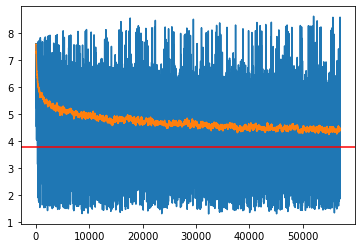

In [4]:
from __future__ import print_function, division
from future.utils import iteritems
from builtins import range, input
import numpy as np
import matplotlib.pyplot as plt
import random
from datetime import datetime
# from google.colab import files
import os
import sys
sys.path.append(os.path.abspath('..'))

if __name__ == '__main__':
    # load in the data
    # note: sentences are already converted to sequences of word indexes
    # note: you can limit the vocab size if you run out of memory
    sentences, word2idx = get_sentences_with_word2idx_limit_vocab(2000)
    # sentences, word2idx = get_sentences_with_word2idx()

    # vocab size
    V = len(word2idx)
    print("Vocab size:", V)

    # we will also treat beginning of sentence and end of sentence as bigrams
    # START -> first word
    # last word -> END
    start_idx = word2idx['START']
    end_idx = word2idx['END']


    # a matrix where:
    # row = last word
    # col = current word
    # value at [row, col] = p(current word | last word)
    bigram_probs = get_bigram_probs(sentences, V, start_idx, end_idx, smoothing=0.1)


    # train a logistic model
    W = np.random.randn(V, V) / np.sqrt(V)

    losses = []
    epochs = 1
    lr = 1e-1
    
    def softmax(a):
        a = a - a.max()
        exp_a = np.exp(a)
        return exp_a / exp_a.sum(axis=1, keepdims=True)

    # what is the loss if we set W = log(bigram_probs)?
    W_bigram = np.log(bigram_probs)
    bigram_losses = []


    t0 = datetime.now()
    for epoch in range(epochs):
        # shuffle sentences at each epoch
        random.shuffle(sentences)

        j = 0 # keep track of iterations
        for sentence in sentences:
            # convert sentence into one-hot encoded inputs and targets
            sentence = [start_idx] + sentence + [end_idx]
            n = len(sentence)
            inputs = np.zeros((n - 1, V))
            targets = np.zeros((n - 1, V))
            inputs[np.arange(n - 1), sentence[:n-1]] = 1
            targets[np.arange(n - 1), sentence[1:]] = 1

            # get output predictions
            predictions = softmax(inputs.dot(W))

            # do a gradient descent step
            W = W - lr * inputs.T.dot(predictions - targets)

            # keep track of the loss
            loss = -np.sum(targets * np.log(predictions)) / (n - 1)
            losses.append(loss)

            # keep track of the bigram loss
            # only do it for the first epoch to avoid redundancy
            if epoch == 0:
                bigram_predictions = softmax(inputs.dot(W_bigram))
                bigram_loss = -np.sum(targets * np.log(bigram_predictions)) / (n - 1)
                bigram_losses.append(bigram_loss)


            if j % 10 == 0:
                print("epoch:", epoch, "sentence: %s/%s" % (j, len(sentences)), "loss:", loss)
            j += 1

    print("Elapsed time training:", datetime.now() - t0)
    plt.plot(losses)

    # plot a horizontal line for the bigram loss
    avg_bigram_loss = np.mean(bigram_losses)
    print("avg_bigram_loss:", avg_bigram_loss)
    plt.axhline(y=avg_bigram_loss, color='r', linestyle='-')


    # plot smoothed losses to reduce variability
    def smoothed_loss(x, decay=0.99):
        y = np.zeros(len(x))
        last = 0
        for t in range(len(x)):
            z = decay * last + (1 - decay) * x[t]
            y[t] = z / (1 - decay ** (t + 1))
            last = z
        return y

    plt.plot(smoothed_loss(losses))

    fig1 = plt.gcf()
    plt.draw() 
    fig1.savefig('smoothed_loss.png', dpi=100)
#     files.download("smoothed_loss.png")
    plt.show()
